# Profile processing Step 1: Pre-processing CTD, identification of data groups, and image tags

works with the raw CTD time series, Castaway processed CTD profiles, and all of the images in the folder to sync the time and create files that will be used in the next step to associate a time, depth, salinity, and temperature with every particle identified by the image processing output. It is in this notebook that you will also select specific intervals within the cast to process (if desired) and identify the total depth (which is needed later on in processing the profile data). Three files are required to complete this step of the processing. They are:

1) raw CTD time series
2) Castaway processed CTD profiles
3) The images to process or the images that were processed 

This notebook can be run before or after the image processing. 

The user input needed in the notebook includes:
- specifying the cast to process through the file ```0_CastPath.csv``` (this file needs to be in the same directory as the step 1 notebook)
- any time corrections to match the images (computer clock) and CTD (CTD clock)
- the image file type (e.g., jpg, bmp, etc.) and the file type of the CTD data (should be .csv)

During the execution of the notebook, you will need to identify whether or not there are breakpoints you want to associate with the cast to group the data and how you want to define the depth. Completing these should be self-explanatory as you work through the file.

Files generated through the execution of this notebook include:

- CTD-profile.csv (a renamed copy for easy read in later on)
- CTD-timeseries.csv (a renamed copy for easy read in later on)
- Data-Breakpionts.csv (a list unique set of data groupings for the cast)
- Depth.csv (depth to be used in later profiling)
- ImageTime.csv (list of image day/times)

## Python loads and functions

In [1]:
%config InlineBackend.figure_format='retina' # hig-res plots for a Retina display 
import numpy as np
import pandas as pd
import os
import glob
from datetime import datetime, timedelta
import shutil

# %matplotlib inline
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
###define equation for converting conductivity to specific conductance
#C - conductivity in microsiemens/cm
#T - temperature in celcius

def SpC(C,T):
    return C/(1+0.02*(T-25))
    
    
#returns the clear-water density in kg/m^3 as a function of temperature [in deg C] and salinity [ppt]
def rho_cw(T,S): 
    rho_fresh=1000*(1-(T +288.9414)/(508929.2*(T+68.12963))*(T-3.9863)**2)
    Acoef = 0.824493 - 0.0040899*T + 0.000076438*T**2 -0.00000082467*T**3 + 0.0000000053675*T**4
    Bcoef = -0.005724 + 0.00010227*T - 0.0000016546*T**2
    return rho_fresh + Acoef*S + Bcoef*S**(3/2) + 0.00048314*S**2 

## Find files and enter time corrections

In [3]:
""" --- User input ----------------------------- """
# file types and paths
filetype = '*.csv'
imagetype = '*jpg'

# time corrections to be added onto CTD to match Camera stamp (use negative number to substract)
hrC = 0  # hour correction
minC = 0 # min correction 
scC = 4   # second correction (Barateria Bay correction)
# scC = 0   # second correction (Siene correction)
"""  ------------------------------------------- """

# castpath = '/Users/strom-adm/Documents/Floc-Processing/Code/1_Profile_Processing/0_CastPath.csv'
castpath = '0_CastPath.csv'
Path = pd.read_csv(castpath).profile_path[0]+'/'

CodePath = os.getcwd()
os.chdir(Path)

# find the data files  

files = sorted(glob.glob(filetype))

for i in range(0,len(files)):
    print('file: ',files[i],'(index: ',i,')')

file:  CTD-profile.csv (index:  0 )
file:  CTD-timeseries.csv (index:  1 )
file:  Data-Breakpionts.csv (index:  2 )
file:  Profile-CC1841005_20210109_184338.csv (index:  3 )
file:  Raw-CC1841005_20210109_184338.csv (index:  4 )
file:  filemod_list.csv (index:  5 )


## Pick files for CTD processing

In [6]:
""" --- User input ----------------------------- """
m = 3 # pick the processed profile data by choosing the file index
n = 4 # pick the raw CTD time series by choosing the file index

## Process CTD

,Time,Depth [m],P [Decibars],T [Celsius],SpC [MicroSiemens/cm],Time (Seconds),Pressure (Decibar),Temperature (Celsius),Conductivity (MicroSiemens per Centimeter),% Device,CC1841005
0,01092021134342,0.000000,0.000000,0.000000,0.000000,0.2,0.000000,8.509108,0.000000,% File name,CC1841005_20210109_184338
1,01092021134342,0.000000,0.000000,0.000000,0.000000,0.4,-0.003185,8.510543,0.000000,% Cast time (UTC),2021-01-09 18:43:38
2,01092021134342,-0.004438,-0.004354,8.511686,0.000000,0.6,-0.003184,8.511530,0.000000,% Cast time (local),2021-01-09 13:43:38
3,01092021134342,-0.006278,-0.006158,8.512778,0.000000,0.8,-0.005311,8.512978,0.000000,% Sample type,Cast
4,01092021134343,-0.007902,-0.007752,8.513658,0.000000,1.0,-0.010089,8.514271,0.000000,% Cast data,Raw
...,...,...,...,...,...,...,...,...,...,...,...
4305,01092021135803,-0.008634,-0.008470,7.622158,1.854445,861.4,-0.010591,7.626507,1.838778,NaN,NaN
4306,01092021135803,-0.006584,-0.006459,7.618549,1.846759,861.6,-0.005823,7.618433,1.852970,NaN,NaN
4307,01092021135803,-0.004101,-0.004023,7.615610,1.846791,861.8,-0.005826,7.607970,1.838785,NaN,NaN
4308,01092021135804,0.000000,0.000000,0.000000,0.000000,862.0,0.002126,7.609807,1.834057,NaN,NaN


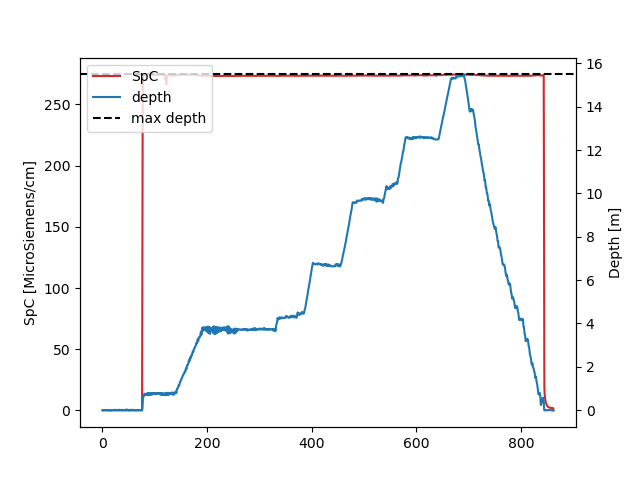

In [8]:
# make a copy of the profile csv so that it is easily read in when creating the super data

if pd.read_csv(files[m],  nrows=1).shape[1] == 2:
    ctd_profile = pd.read_csv(files[m], skiprows = 28)
    ctd_profile.to_csv('CTD-profile.csv',index = False)
else:
    shutil.copyfile(files[m], 'CTD-profile.csv')

# get the ctd file, rearrange it and make it into a dataframe 

ctd_data = pd.read_csv(files[n], skiprows = 28)
ctd_header = pd.read_csv(files[n], nrows = 27)
ctd = pd.concat([ctd_data, ctd_header], axis=1)

# associated a full corrected day and time stamp with each time series measurement

cor_time = ctd.iloc[2,5]
cor_time = datetime.strptime(cor_time,'%Y-%m-%d %H:%M:%S')
cor_time = cor_time + timedelta(hours=hrC,minutes=minC,seconds=scC)    ##Change time to CST

N = len(ctd.iloc[:,0])
cor_timess = np.empty(N, dtype=object)
for i in np.arange(0,N):
    cor_times = cor_time + timedelta(seconds = ctd.iloc[i,0])
    cor_timess[i] = cor_times.strftime("%m%d%Y%H%M%S") 
    
# average P,T,C from CTD data, calculate specific conductance from C and convert P to depth

avg_ctd_P = np.zeros(N)
avg_ctd_T = np.zeros(N)
avg_ctd_C = np.zeros(N)
for i in np.arange(2,N-2):
    avg_ctd_P[i] = np.average([ctd.iloc[i-2,1],ctd.iloc[i-1,1],ctd.iloc[i,1],ctd.iloc[i+1,1],ctd.iloc[i+2,1]])
    avg_ctd_T[i] = np.average([ctd.iloc[i-2,2],ctd.iloc[i-1,2],ctd.iloc[i,2],ctd.iloc[i+1,2],ctd.iloc[i+2,2]])
    avg_ctd_C[i] = np.average([ctd.iloc[i-2,3],ctd.iloc[i-1,3],ctd.iloc[i,3],ctd.iloc[i+1,3],ctd.iloc[i+2,3]])
    
avg_SpC = SpC(avg_ctd_C,avg_ctd_T)      #microsiemens/cm
depth = avg_ctd_P*10/9.81               #meters 

# insert data into ctd dataframe and save as a csv file

ctd.insert(0,'Time',cor_timess)
ctd.insert(1,'Depth [m]',depth)
ctd.insert(2,'P [Decibars]',avg_ctd_P)
ctd.insert(3,'T [Celsius]',avg_ctd_T)
ctd.insert(4,'SpC [MicroSiemens/cm]',avg_ctd_C)

ctd.to_csv('CTD-timeseries.csv',index = False)

display(ctd)

# auto set the max detph
maxdepth = max(ctd['Depth [m]'])

# plot the data
fig, ax1 = plt.subplots()
ax1.plot(ctd['Time (Seconds)'], ctd['SpC [MicroSiemens/cm]'], color='C03',alpha=1,label='SpC')
ax1.set_ylabel('SpC [MicroSiemens/cm]')
# ax1.set_ylim(33000,37000)
ax2 = ax1.twinx()
ax2.plot(ctd['Time (Seconds)'], ctd['Depth [m]'], alpha=1,label='depth')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Depth [m]')
ax2.axhline(y = maxdepth, color = 'k', linestyle = '--', label='max depth')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc=2);

## Identify the break points for specific subsets of the data and the max depth

In [9]:
""" --- User input ----------------------------- """
subsets = 1 # enter "1" to have subsets, zero for none
automax = 1 # use "1" to just take the max of the measurement. Set automax = 0 to use a user-specified value (then must set manual max below)
# manualmax = 12.8 # Set max depth manually

# Time breakpoints... enter the start and end of each period or subset for which you want the data grouped (use nearest second)

# Mississippi - --------------------------------

names = np.array(['surface','d1','d2','d3','d4','d5','d6','bottom','profile'])

startS = np.array([81,191,334,402,479,543,580,666,693]) # SWP1
endS = np.array([141,329,385,455,535,564,642,692,839]) # SWP1

# # Seine - 4/17/2022 --------------------------------

# names = np.array(['profile','surface','mid-depth','bottom'])

# startS = np.array([62,235,358,458]) # profile 4
# endS = np.array([234,322,415,528]) # profile 4

# # Seine - 6/16/2022 --------------------------------

# names = np.array(['profile','surface','mid-depth','bottom'])

# startS = np.array([180,338,553,714]) # profile 4
# endS = np.array([338,518,679,832]) # profile 4


"""  ------------------------------------------- """



if automax == 0:
    maxdepth = manualmax
else:
    waterdepth = pd.DataFrame({'Depth [m]':np.array([maxdepth])})
    waterdepth.to_csv('Depth.csv',index=False)
    
if subsets == 1:
    
    deltaT = endS - startS
    start_time = np.zeros(len(startS))
    end_time = np.zeros(len(endS))

    for i in range(0,len(startS)):
        temp = ctd[(ctd['Time (Seconds)'] == startS[i])].copy()
        start_time[i] = temp.Time.iloc[0]

    for i in range(0,len(endS)):
        temp = ctd[(ctd['Time (Seconds)'] == endS[i])].copy()
        end_time[i] = temp.Time.iloc[0]

    breaktimes = pd.DataFrame({'Type/Location':names,'Start [DateTime]':start_time, 'End [DateTime]':end_time, 'Durration [sec]':deltaT})
    breaktimes.to_csv('Data-Breakpionts.csv',index = False)
    display(breaktimes)



,Type/Location,Start [DateTime],End [DateTime],Durration [sec]
0,surface,1.092021e+12,1.092021e+12,60
1,d1,1.092021e+12,1.092021e+12,138
2,d2,1.092021e+12,1.092021e+12,51
3,d3,1.092021e+12,1.092021e+12,53
4,d4,1.092021e+12,1.092021e+12,56
5,d5,1.092021e+12,1.092021e+12,21
6,d6,1.092021e+12,1.092021e+12,62
7,bottom,1.092021e+12,1.092021e+12,26
8,profile,1.092021e+12,1.092021e+12,146


## Save the depth to be used later on

In [10]:
pd.DataFrame({'Depth [m]':np.array([maxdepth])})

,Depth [m]
0,15.491777


## Extract time stamps from images and save as a csv file

In [11]:
# find the list of images, build a dataframe, and then extract the date time

# uses the filemod_list.csv file ---------------

images = pd.read_csv('filemod_list.csv', usecols = ['file_Name'])

N = len(images)
datetime_raw = np.empty(N, dtype=object)
for i in np.arange(0,N):
    datetime_raw[i] = str(images.iloc[i,0].split('-')[1]) #adjust the number in brackets until the datetime_raw is the timestamp. This will depend on how you named the images in the field. 
images['Image Time']=datetime_raw
images.to_csv('ImageTime.csv', index=False)
display(images)

# uses the actual image files -----------------
# Ifiles = sorted(glob.glob(imagetype))
# images=pd.DataFrame(Ifiles)

# N = len(images)
# datetime_raw = np.empty(N, dtype=object)
# for i in np.arange(0,N):
#     datetime_raw[i] = str(images.iloc[i,0].split('-')[1]) #adjust the number in brackets until the datetime_raw is the timestamp. This will depend on how you named the images in the field. 
# images['Image Time']=datetime_raw
# images.to_csv('ImageTime.csv', index=False)
# display(images)

# imagehold = images[(images['Image Time'] >= breaktime)].copy()
# imagehold.to_csv('ImageTime-hold.csv',index = False)
# print("Only during the hold ------------")
# display(imagehold)

,file_Name,Image Time
0,SWP1-01092021134459-13.Bmp,01092021134459
1,SWP1-01092021134459-14.Bmp,01092021134459
2,SWP1-01092021134500-15.Bmp,01092021134500
3,SWP1-01092021134501-17.Bmp,01092021134501
4,SWP1-01092021134502-18.Bmp,01092021134502
...,...,...
967,SWP1-01092021135742-1252.Bmp,01092021135742
968,SWP1-01092021135742-1253.Bmp,01092021135742
969,SWP1-01092021135743-1254.Bmp,01092021135743
970,SWP1-01092021135744-1255.Bmp,01092021135744


In [12]:
# change the working directory back to the original code path
os.chdir(CodePath)